## Import Lib

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.utils import plot_model
from PIL import Image
import tensorflow as tf

warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#!pip install gdown
#import gdown
#gdown.download_folder('https://drive.google.com/drive/folders/13ZK9hPhP_ONyzuNLKlCweC9KVIAb1MNq?usp=sharing', quiet=False)

Mounted at /content/drive


In [3]:
BASE_DIR = '/content/drive/My Drive//UTKFace'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/3517 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  /content/drive/My Drive//UTKFace/85_1_0_201701...   85       1
1  /content/drive/My Drive//UTKFace/85_0_2_201701...   85       0
2  /content/drive/My Drive//UTKFace/85_1_0_201701...   85       1
3  /content/drive/My Drive//UTKFace/85_1_0_201701...   85       1
4  /content/drive/My Drive//UTKFace/85_0_1_201701...   85       0

In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

## Visualisasi Data

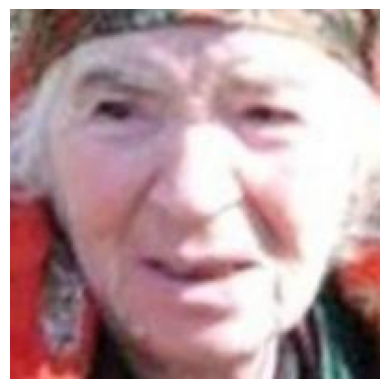

In [7]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

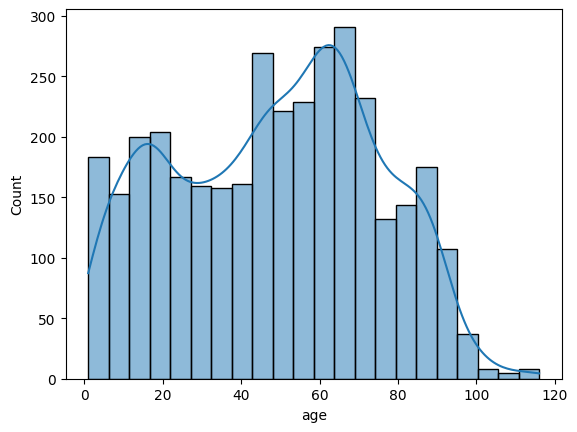

In [8]:
sns.histplot(df['age'], kde=True)  # Menampilkan histogram dengan KDE
plt.show()

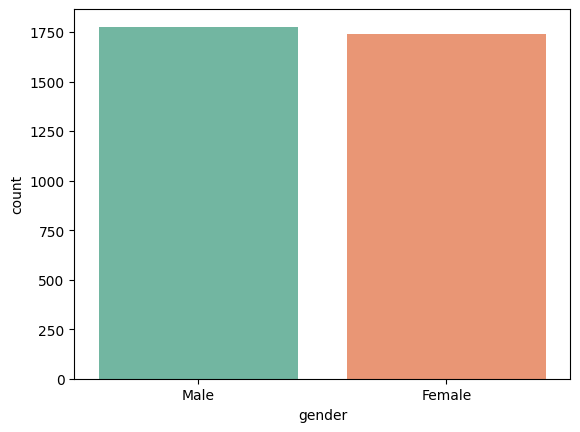

In [9]:
sns.countplot(x=df['gender'], palette='Set2')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

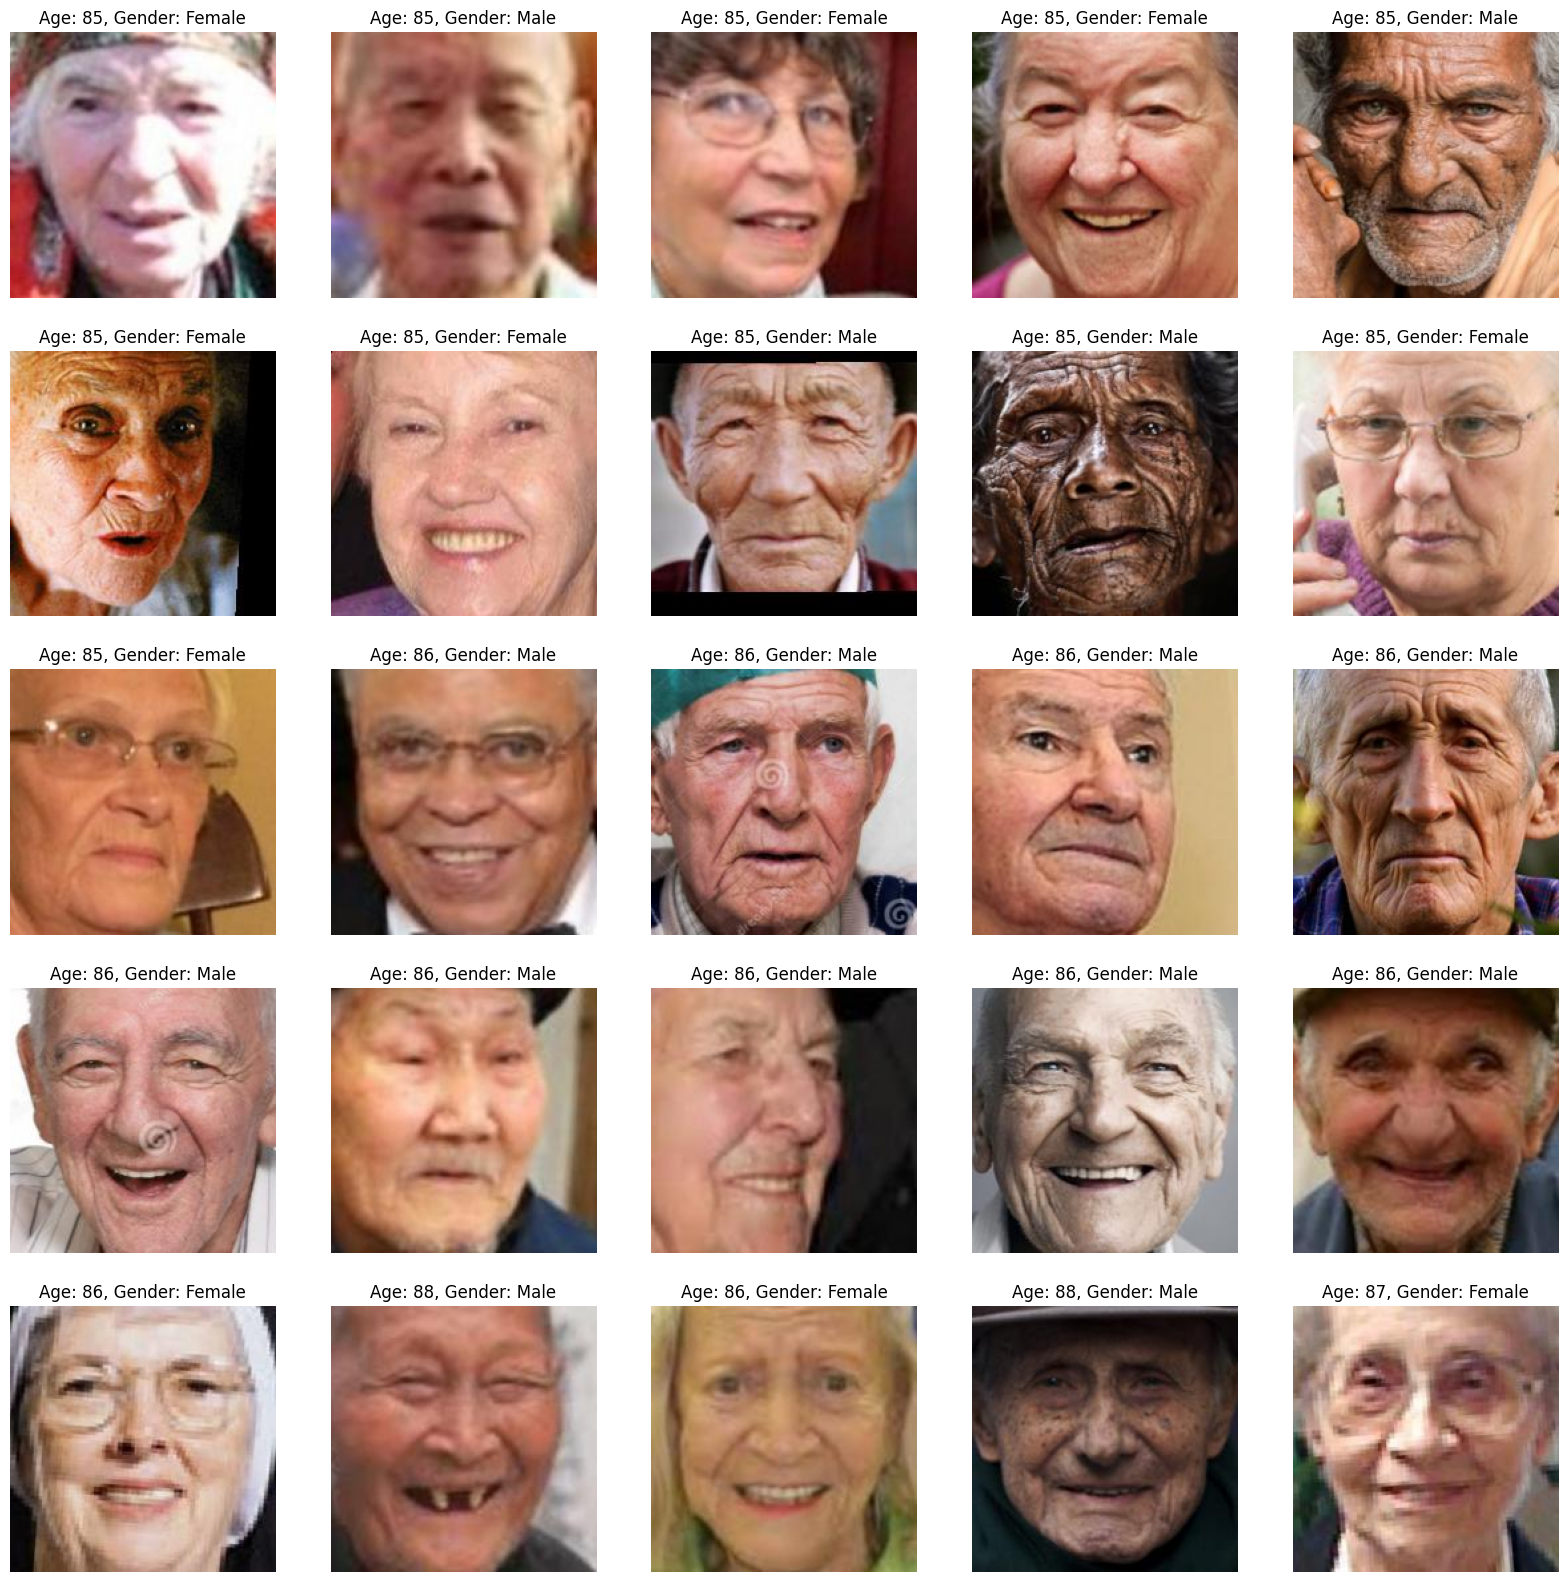

In [10]:
# Display grid of sample images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, (file, age, gender) in enumerate(files[['image', 'age', 'gender']].values):
    plt.subplot(5, 5, index + 1)
    img = load_img(file)
    plt.imshow(img)
    plt.title(f"Age: {age}, Gender: {gender_dict[gender]}")
    plt.axis('off')
plt.show()

## Pre-Prosessing Data

In [11]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Memuat gambar sebagai RGB (3 saluran)
        img = load_img(image, color_mode='rgb')  # Pastikan 'rgb' sebagai color_mode
        img = np.array(img)  # Mengubah gambar menjadi array numpy

        # Resize gambar menjadi 128x128
        img = Image.fromarray(img)  # Mengonversi kembali array menjadi gambar
        img = img.resize((128, 128), Image.Resampling.LANCZOS)  # Resize image ke 128x128

        features.append(np.array(img))

    features = np.array(features)
    # Mengubah bentuk menjadi (jumlah_gambar, 128, 128, 3) untuk RGB
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/3517 [00:00<?, ?it/s]

In [13]:
X.shape

(3517, 128, 128, 3)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 3)

## Pelatihan Model

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Load VGG16 pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers initially
for layer in base_model.layers[-4:]:  # Membuka 4 lapisan terakhir
    layer.trainable = True

# Add custom layers
x = base_model.output
x = Flatten()(x)
dense_1 = Dense(256, activation='relu')(x)
dropout_1 = Dropout(0.4)(dense_1)
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)

dense_2 = Dense(256, activation='relu')(x)
dropout_2 = Dropout(0.4)(dense_2)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Combine the base model with new custom layers
model = Model(inputs=base_model.input, outputs=[output_1, output_2])

# Compile the model
model.compile(
    loss=['binary_crossentropy', 'mae'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics={'gender_out': 'accuracy', 'age_out': 'mae'}
)

# Print the model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 18,910,018 (72.14 MB)

 Trainable params: 18,910,018 (72.14 MB)

 Non-trainable params: 0 (0.00 B)

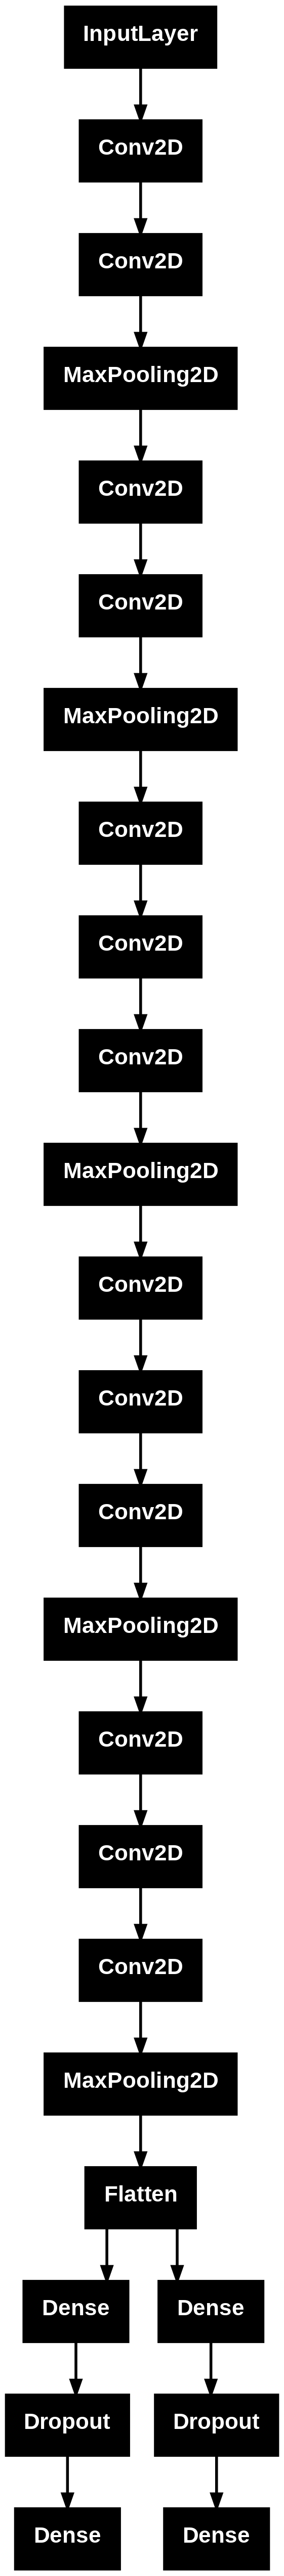

In [18]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
from sklearn.model_selection import train_test_split

# Split dataset into training and validation sets
X_train, X_val, y_gender_train, y_gender_val, y_age_train, y_age_val = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42
)

# Train the model
history = model.fit(
    X_train,
    [y_gender_train, y_age_train],  # Multiple outputs
    validation_data=(X_val, [y_gender_val, y_age_val]),
    epochs=30,  # Set to desired number of epochs
    batch_size=32,  # Adjust batch size as needed
    verbose=1
)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 66s 436ms/step - age_out_loss: 33.5562 - age_out_mae: 33.5565 - gender_out_accuracy: 0.5508 - gender_out_loss: 0.9597 - loss: 34.5162 - val_age_out_loss: 14.6010 - val_age_out_mae: 14.6010 - val_gender_out_accuracy: 0.7798 - val_gender_out_loss: 0.4834 - val_loss: 15.0844
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 36s 166ms/step - age_out_loss: 13.8494 - age_out_mae: 13.8494 - gender_out_accuracy: 0.7412 - gender_out_loss: 0.6331 - loss: 14.4826 - val_age_out_loss: 11.0882 - val_age_out_mae: 11.0882 - val_gender_out_accuracy: 0.8452 - val_gender_out_loss: 0.3431 - val_loss: 11.4313
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - age_out_loss: 11.6662 - age_out_mae: 11.6663 - gender_out_accuracy: 0.7871 - gender_out_loss: 0.4694 - loss: 12.1357 - val_age_out_loss: 11.1793 - val_age_out_mae: 11.1793 - val_gender_out_accuracy: 0.8793 - val_gender_out_loss: 0.2938 - val_loss: 11.4731
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - age_out_loss

## Hasil dan Evaluasi

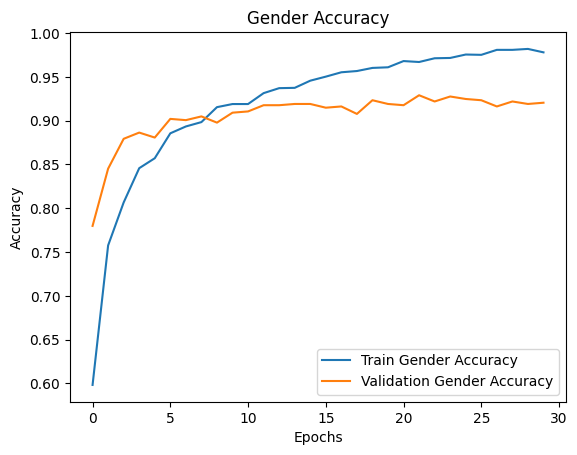

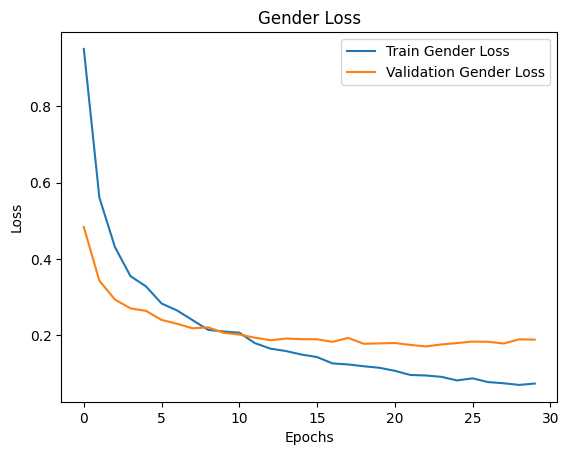

In [20]:
# Gender Accuracy
plt.plot(history.history['gender_out_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_out_accuracy'], label='Validation Gender Accuracy')
plt.legend()
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Gender Loss
plt.plot(history.history['gender_out_loss'], label='Train Gender Loss')
plt.plot(history.history['val_gender_out_loss'], label='Validation Gender Loss')
plt.legend()
plt.title('Gender Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

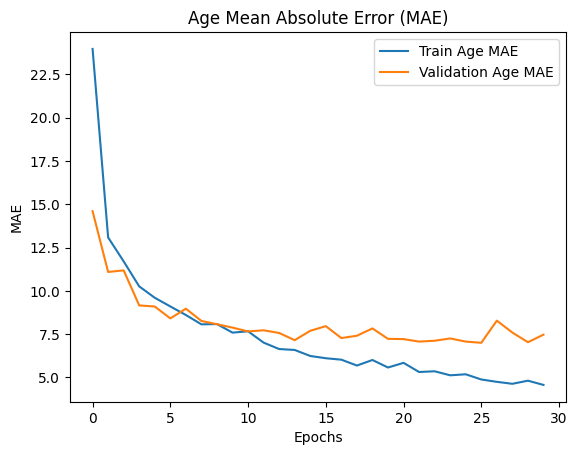

In [21]:
# Age MAE
plt.plot(history.history['age_out_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_out_mae'], label='Validation Age MAE')
plt.legend()
plt.title('Age Mean Absolute Error (MAE)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step


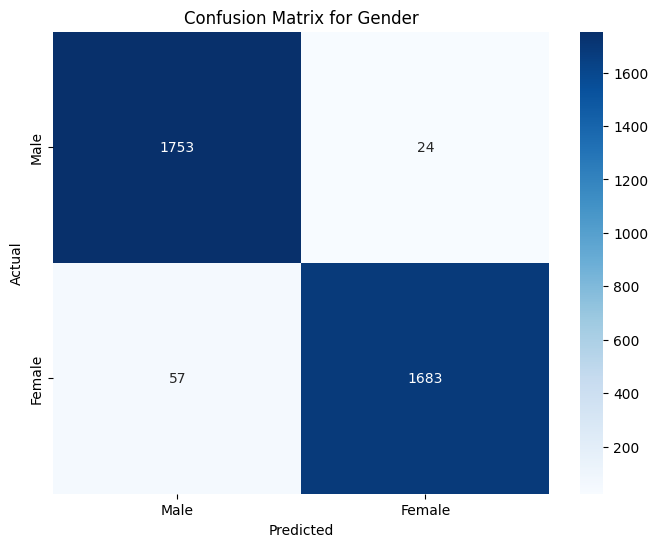

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the validation set
y_pred_gender, _ = model.predict(X)

# Convert probabilities to class labels (0 or 1)
y_pred_gender_classes = (y_pred_gender > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_gender, y_pred_gender_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gender')
plt.show()

In [23]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score

# Membagi data uji (contoh: menggunakan 20% data validasi sebagai test set)
X_test = X[int(0.8 * len(X)):]
y_gender_test = y_gender[int(0.8 * len(y_gender)):]
y_age_test = y_age[int(0.8 * len(y_age)):]

# Prediksi menggunakan model
predictions = model.predict(X_test)
predicted_gender = (predictions[0] > 0.5).astype(int).flatten()  # Biner untuk gender
predicted_age = predictions[1].flatten()  # Kontinu untuk age

# Laporan untuk gender
print("Gender Classification Report:")
print(classification_report(y_gender_test, predicted_gender, target_names=['Male', 'Female']))

# Evaluasi untuk age menggunakan MAE, RMSE, dan R-squared
age_mae = mean_absolute_error(y_age_test, predicted_age)
print("\nAge Regression Report:")
print(f"Mean Absolute Error (MAE): {age_mae:.2f}")

# Hitung RMSE
age_rmse = np.sqrt(mean_squared_error(y_age_test, predicted_age))
print(f"Root Mean Squared Error (RMSE): {age_rmse:.2f}")

# Hitung R-squared
age_r2 = r2_score(y_age_test, predicted_age)
print(f"R-squared: {age_r2:.2f}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Gender Classification Report:
              precision    recall  f1-score   support

        Male       0.97      0.99      0.98       348
      Female       0.99      0.97      0.98       356

    accuracy                           0.98       704
   macro avg       0.98      0.98      0.98       704
weighted avg       0.98      0.98      0.98       704


Age Regression Report:
Mean Absolute Error (MAE): 3.54
Root Mean Squared Error (RMSE): 5.66
R-squared: 0.94


# Tes Dataset Untuk Prediksi

Original Gender: Female Original Age: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Gender: Female Predicted Age: 8


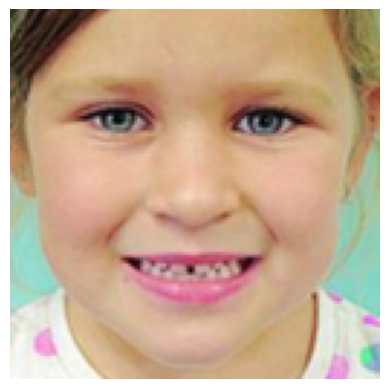

In [24]:
image_index = 125
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))  # Perhatikan perubahan shape menjadi (1, 128, 128, 3)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Visualisasi gambar
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3));  # Visualisasi gambar dalam RGB


Original Gender: Female Original Age: 88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Female Predicted Age: 88


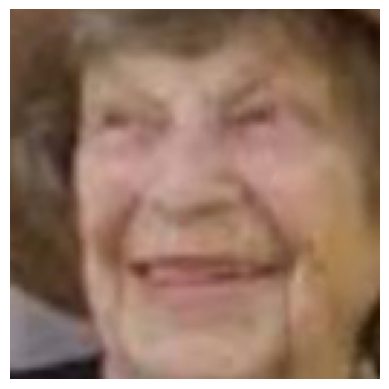

In [32]:
image_index = 67
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))  # Perhatikan perubahan shape menjadi (1, 128, 128, 3)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Visualisasi gambar
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3));  # Visualisasi gambar dalam RGB


Original Gender: Male Original Age: 60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 57


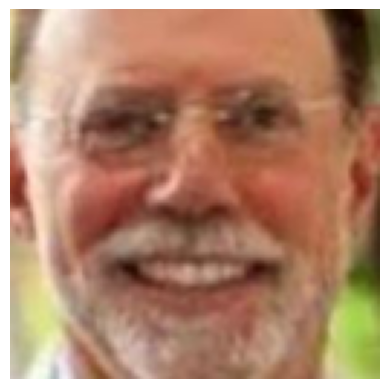

In [34]:
image_index = 1000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))  # Perhatikan perubahan shape menjadi (1, 128, 128, 3)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Visualisasi gambar
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3));  # Visualisasi gambar dalam RGB


Original Gender: Male Original Age: 90
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Gender: Male Predicted Age: 77


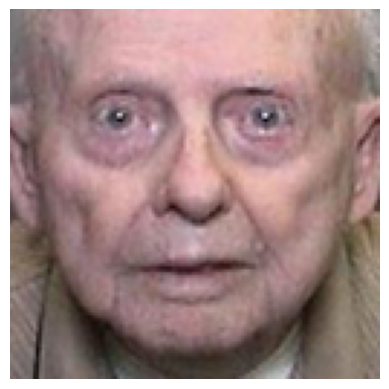

In [28]:
image_index = 155
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 3))  # Perhatikan perubahan shape menjadi (1, 128, 128, 3)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Visualisasi gambar
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128, 3));  # Visualisasi gambar dalam RGB
